# Data Loading

In [2]:
import numpy as np
import cv2
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

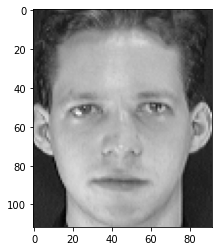

In [3]:
test_image = cv2.imread('archive/s1/1.pgm', -1)
plt.imshow(test_image, cmap='gray')
plt.show()

In [4]:
dataset = []
labels = []
for folder_index in range(1, 40 + 1):
    for file_index in range(1, 10+1):
        file_name = f'archive/s{folder_index}/{file_index}.pgm'
        image = cv2.imread(file_name, -1).astype(np.float32)
        dataset.append(image.reshape(-1))
        labels.append(folder_index)
dataset = np.array(dataset)
labels = np.array(labels).reshape(-1, 1)

print(dataset.shape)

(400, 10304)


In [5]:
def my_train_test_split(X, y):
    trainX = X[::2,  : ]
    testX  = X[1::2, : ]
    trainY = y[::2,  : ]
    testY  = y[1::2, : ]
    return trainX, testX, trainY, testY

trainX, testX, trainY, testY = my_train_test_split(dataset, labels)
print(trainX.shape, testX.shape)

(200, 10304) (200, 10304)


(200, 10305)
(200, 10304) (200, 1)


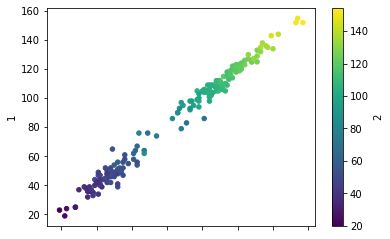

In [6]:
df = pd.DataFrame(data = np.concatenate((trainX, testY), axis=1))
df.plot.scatter(x=0, y=1, c=2, colormap = 'viridis')
print(df.shape)
print(trainX.shape, testY.shape)

# PCA

In [11]:
class MyPCA:
    def __init__(self, alpha):
        self.alpha = alpha

    def fit(self, X):
        self.U, self.mu = self._implementation(X, self.alpha)
        
    def fit_transform(self, X):
        self.U, self.mu = self._implementation(X, self.alpha)
        centered = X - self.mu
        return centered @ self.U

    def predict(self, X):
        centered = X - self.mu
        return centered @ self.U
        
    def _implementation(self, X, alpha):
        mu = np.mean(X, axis=0)
        Z = X - mu
        cov_mat = Z.T @ Z / Z.shape[0]
        eig_vals, eig_vecs = np.linalg.eigh(cov_mat)

        eig_vals_cumsum = np.cumsum(eig_vals[::-1]) / np.sum(eig_vals)
        rank = np.where(eig_vals_cumsum >= alpha)[0][0] + 1
        return eig_vecs[:, :-(rank + 1):-1], mu

## Testing PCA with Different Alphas

In [31]:
# returns average accuracy of KNN classification with k = 1
def simple_knn(trainX, testX, trainY, testY):
    acc = 0
    for i in range(len(testX)):
        # Distance from each train image to test image[i]
        norm_array = np.linalg.norm(trainX - testX[i, :], axis=1) 
        
        # Get the index of the smallest norm
        nearest_neighbour = np.argmin(norm_array)
        
        acc += trainY[nearest_neighbour] == testY[i]
    return acc / len(testX) * 100

In [32]:
alphas = [0.8,0.85,0.9,0.95]
accuracy = []

for alpha in alphas:
    pca = MyPCA(alpha)
    pca.fit(trainX)
    
    # Project the images
    pca_reduced_train_X = pca.predict(trainX)
    pca_reduced_test_X = pca.predict(testX)
    
    print(pca_reduced_train_X.shape, pca_reduced_test_X.shape)
    
    
    avg_acc = simple_knn(pca_reduced_train_X, pca_reduced_test_X, trainY, testY)
    accuracy.append(avg_acc)

(200, 36) (200, 36)
(200, 51) (200, 51)
(200, 76) (200, 76)
(200, 115) (200, 115)


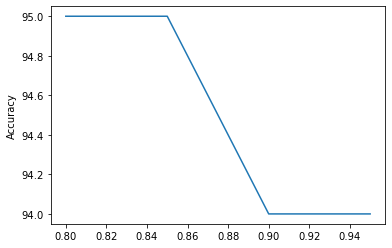

In [33]:
plt.ylabel("Accuracy")
plt.plot(alphas, accuracy)

In [56]:
# Fitting a PCA with alpha = 0.8 to use in the rest of the notebook
pca = MyPCA(0.8)
pca.fit(trainX)
pca_reduced_train_X = pca.predict(trainX)
pca_reduced_test_X = pca.predict(testX)

# LDA

In [27]:
#
#   LDA helper functions
#

def split_data_classes(X, y):
    num_labels = len(np.unique(y))
    D = [[] for i in range(num_labels)]
    for i, instance in enumerate(X):
        label_index = y[i][0]-1
        D[label_index].append(instance)
    return D


def calculate_class_means(D):
    mu = []
    for i in range(len(D)):
        mu.append(np.mean(D[i], axis=0))
    return np.array(mu)

def center_class_matrices(D, mu):
    Z = []
    for i in range(len(D)):
      Z.append(D[i] - mu[i])
    return Z


def calculate_Sb(D, mu, d, overall_mean): # between class scatter matrix
    Sb = np.zeros((d,d))
    for k in range(len(D)):
        nk = len(D[k])
        temp = np.subtract(mu[k], overall_mean)
        Sb += nk * np.outer(temp, temp)
    return Sb


def calculate_S_total(D, mu, d): # within-class scatter matrix
    S_total  = np.zeros((d,d))
    for i in range(len(D)):
        Z = D[i] - mu[i]
        S_total += Z.T @ Z
    return S_total

In [43]:
class MyLDA:

    def fit(self, X, y):
        self.U = self._implementation(X, y)
        
    def project(self, X):
        return X @ self.U
        
    def _implementation(self, X, y):
        n = X.shape[0]
        d = X.shape[1]
        
        overall_mean = np.mean(X, axis=0)
        D = split_data_classes(X, y)
        mu = calculate_class_means(D)


        Sb = calculate_Sb(D, mu, d, overall_mean)

        S_total = calculate_S_total(D, mu, d)

        eig_vals, eig_vecs = np.linalg.eigh(np.linalg.inv(S_total) @ Sb)
        idx = eig_vals.argsort()[::-1]     # get order of sorted eigen values and use it to sort the eigen vectors
        eig_vecs = eig_vecs[:, idx]

        eig_vecs = eig_vecs[:, :-(39 + 1): -1]
        return eig_vecs


    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.project(X)

    
lda = MyLDA()
lda.fit(trainX, trainY)

## LDA: More efficient and compact implementation 

In [ ]:
class LDA_efficient:
    def _implementation(self, X, y):
        labels, counts = np.unique(y, return_counts=True)
        D = []

        for label in labels:
            D.append(X[(y == label).flatten()])
        D = np.array(D)

        class_mu = np.mean(D, axis=1)
        dataset_mu = np.mean(D, axis=(1, 0))
        mu_centered = class_mu - dataset_mu

        print("Class_mu = ")
        print(class_mu.shape)
        print(class_mu[0])
        print("----------------------")


        Sb = mu_centered.T @ np.diag(counts) @ mu_centered
        Z = D - class_mu[:, None, :]
        S_total = np.einsum('ijk,ijm->km', Z, Z)

        _, eig_vecs = np.linalg.eigh(np.linalg.inv(S_total) @ Sb)

        U = eig_vecs[:, :-(39 + 1): -1]

        print(Sb)
        print(S_total)
        print(U)

        return U
            
    def fit(self, X, y):
        self.U = self._implementation(X, y)
    
    def predict(Self, X):
        return X @ Self.U

    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.predict(X)

In [ ]:
lda_ef = LDA_efficient()
lda_ef.fit(trainX, trainY)

In [55]:
lda_reduced_train_X = lda.project(trainX)
lda_reduced_test_X = lda.project(testX)
# reduced_train_X = lda_ef.predict(trainX)
# reduced_test_X = lda_ef.predict(testX)

print(lda_reduced_train_X.shape, trainY.shape, lda_reduced_test_X.shape, testY.shape)
avg_acc = simple_knn(lda_reduced_train_X, lda_reduced_test_X, trainY, testY)
print(avg_acc)

(200, 39) (200, 1) (200, 39) (200, 1)
[93.]


# KNN

In [53]:
from sklearn.neighbors import KNeighborsClassifier

def plotKNN(train_X, train_Y, test_X, test_Y):
    scores = []
    for nei in range(1, 15, 2):
        KNN = KNeighborsClassifier(n_neighbors=nei)
        KNN.fit(train_X, np.ravel(train_Y))
        score = KNN.score(test_X, np.ravel(test_Y))
        scores.append([nei,score])
    print(scores)
    pd.DataFrame(data=scores).plot(x=0, y=1)

[[1, 0.95], [3, 0.895], [5, 0.85], [7, 0.805], [9, 0.78], [11, 0.73], [13, 0.695]]


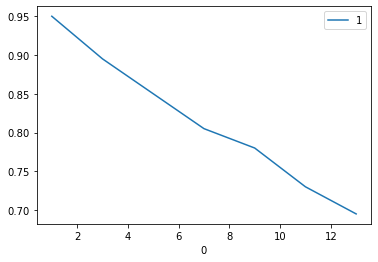

In [57]:
# PCA
plotKNN(pca_reduced_train_X, trainY, pca_reduced_test_X, testY)

[[1, 0.93], [3, 0.87], [5, 0.825], [7, 0.8], [9, 0.765], [11, 0.715], [13, 0.655]]


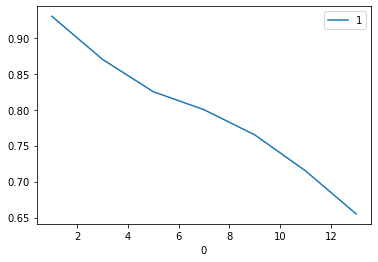

In [58]:
# LDA
plotKNN(lda_reduced_train_X, trainY, lda_reduced_test_X, testY)

<AxesSubplot:xlabel='0', ylabel='2'>

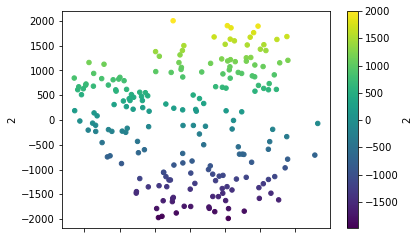

In [59]:
df = pd.DataFrame(data = np.concatenate((reduced_train_X, trainY), axis=1))
df.plot.scatter(x=0, y=2, c=2, colormap = 'viridis')

(200, 116)
(200, 115) (200, 1)


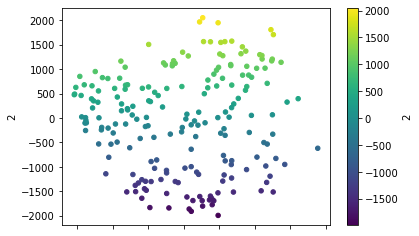

In [60]:
df = pd.DataFrame(data = np.concatenate((reduced_test_X, testY), axis=1))
df.plot.scatter(x=0, y=2, c=2, colormap = 'viridis')
print(df.shape)
print(reduced_test_X.shape, testY.shape)

miss-classified examples:


D:\Programs\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


<AxesSubplot:xlabel='0', ylabel='2'>

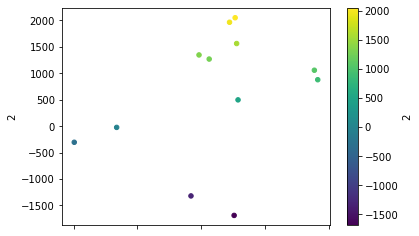

In [61]:
KNN = KNeighborsClassifier(n_neighbors=1)
KNN.fit(reduced_train_X, trainY)
Ys = KNN.predict(reduced_test_X)

print("miss-classified examples:")
z = np.array(np.where(Ys != testY.flatten()))[0]
df[df.index.isin(z)].plot.scatter(x=0,y=2,c=2, colormap='viridis')

In [ ]:
# from scipy.stats import mode
# class MyKNN:
#     def __init__(self, X, y, n_neighbors):
#         self.X = X
#         self.y = y
#         self.n_neighbors = n_neighbors
    
#     def predict(self, X_test):
#         ans = []

#         for datapoint in X_test:
#             norms = np.linalg.norm(self.X - datapoint, axis=1)
#             indices = np.argpartition(norms, self.n_neighbors)[:self.n_neighbors]
#             predictions = self.y[indices]
#             ans.append(mode(predictions)[0][0])
        
#         return np.array(ans).reshape(-1, 1)

In [ ]:
# for k in range(1, 9+1, 2):
#     clf = MyKNN(reduced_train_X, trainY, k)
#     predictions = clf.predict(reduced_test_X)
#     print(f'accuracy for KNN with {k} neighbors = {(predictions.flatten() == testY.flatten()).sum() / len(testY) * 100.0}%')

In [ ]:
# test_image = cv2.imread('resized.JPEG', -1)
# print(test_image.shape)
# plt.imshow(test_image, cmap='gray')

# faces vs non-facess

In [ ]:
non_faces_folder_path = '../input/nonfaces' #modify
img = cv2.imread(non_faces_folder_path + '/(90).pgm', -1);
print(img.shape)
plt.imshow(img, cmap = 'gray')

In [ ]:
def load_images(num_images):
    dataset = []
    labels = []
    for image_index in range(1, num_images + 1):
        file_name = f'{non_faces_folder_path}/({image_index}).pgm'
        image = cv2.imread(file_name, -1).astype(np.float32)
        dataset.append(image.reshape(-1))
        labels.append(0)
    dataset = np.array(dataset)
    labels = np.array(labels).reshape(-1, 1)
    return dataset, labels

non_faces_dataset, non_faces_labels = load_images(100)
print(non_faces_dataset.shape)

In [ ]:
## trainX, trainY, testX, testY
print(dataset.shape, labels.shape)

In [ ]:
faces_dataset = dataset
faces_labels = np.ones((dataset.shape[0],1), dtype=int)
n = non_faces_dataset.shape[0] + faces_dataset.shape[0]

all_labels = np.concatenate((faces_labels, non_faces_labels), axis=0)
all_dataset = np.concatenate((faces_dataset, non_faces_dataset), axis=0)

print(all_labels.shape, all_dataset.shape)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(all_dataset, all_labels, test_size=0.33, random_state=42)

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [ ]:
pca = MyPCA(0.9)
pca.fit(X_train)
reduced_X_train = pca.predict(X_train)
reduced_X_test = pca.predict(X_test)
print(reduced_X_train.shape, reduced_X_test.shape)

In [ ]:
plotKNN(reduced_X_train, y_train, reduced_X_test, y_test)

## LDA

In [ ]:
print(X_train.shape, y_train.shape)


In [ ]:
lda_ef = MyLDA()
lda_ef.fit(X_train, y_train)
reduced_train_X = lda_ef.project(X_train)
reduced_test_X = lda_ef.project(X_test)
print(reduced_X_train.shape, reduced_X_test.shape)
plotKNN(reduced_X_train, y_train, reduced_X_test, y_test)

# plot non_faces count vs accuracy 

In [ ]:
scores = []
for num_non_faces in range(50, 401, 50):
    non_faces_dataset, non_faces_labels = load_images(num_non_faces)
    faces_dataset = dataset
    faces_labels = np.ones((dataset.shape[0],1), dtype=int)
    
    # cobine faces and non_faces
    all_labels = np.concatenate((faces_labels, non_faces_labels), axis=0)
    all_dataset = np.concatenate((faces_dataset, non_faces_dataset), axis=0)
    
    X_train, X_test, y_train, y_test = train_test_split(all_dataset, all_labels, test_size=0.33, random_state=42)
    
    pca = MyPCA(0.9)
    pca.fit(X_train)
    reduced_X_train = pca.predict(X_train)
    reduced_X_test = pca.predict(X_test)
    print(reduced_X_train.shape, reduced_X_test.shape)
    
    KNN = KNeighborsClassifier(n_neighbors=1)
    KNN.fit(reduced_X_train, y_train)
    score = KNN.score(reduced_X_test, y_test)
    scores.append([num_non_faces,score])
    print("new score",num_non_faces,score)
    
pd.DataFrame(data=scores).plot(x=0, y=1)

# Bonus: Different train-test split

In [67]:
trainX = []
trainY = []
testX = []
testY = []

for folder_index in range(1, 40 + 1):
    for file_index in range(1, 10+1):
        file_name = f'archive/s{folder_index}/{file_index}.pgm'
        image = cv2.imread(file_name, -1).astype(np.float32)
        
        if file_index <= 7: 
            trainX.append(image.reshape(-1))
            trainY.append(folder_index)
        else:
            testX.append(image.reshape(-1))
            testY.append(folder_index)
            
trainX = np.array(trainX)
trainY = np.array(trainY).reshape(-1, 1)
testX = np.array(testX)
testY = np.array(testY).reshape(-1, 1)

print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(280, 10304) (280, 1) (120, 10304) (120, 1)


In [68]:
# using the best config: K = 1, alpha = 0.8
pca = MyPCA(0.8)
pca.fit(trainX)
pca_reduced_train_X = pca.predict(trainX)
pca_reduced_test_X = pca.predict(testX)

lda = MyLDA()
lda.fit(trainX, trainY)
lda_reduced_train_X = lda.project(trainX)
lda_reduced_test_X = lda.project(testX)

In [69]:
print(f"PCA: {simple_knn(pca_reduced_train_X, pca_reduced_test_X, trainY, testY)}")
print(f"LDA: {simple_knn(lda_reduced_train_X, lda_reduced_test_X, trainY, testY)}")

PCA: [95.83333333]
LDA: [95.]
